# Wide Neural Network

An implementation of Zheng's Wide Neural Network (WNN).

# Imports

In [0]:
import numpy as np
import pandas as pd 

# Regular expression library (just so I can automate auc key extraction)
import re

# Plotting imports - Seaborn
from seaborn import distplot, heatmap

# Plotting imports - Matplotlib
import matplotlib.pyplot as plt 
from matplotlib import style
style.use('ggplot')

# Scikit-Learn imports
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix, classification_report, roc_auc_score, roc_curve

# Have to use Tensorflow's distribution of Keras for compatibility with metrics
%tensorflow_version 2.x
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.metrics import AUC
from tensorflow.keras.regularizers import l2
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

# Functions


### Function 1 - Feature Scaler 

Defining a single function to help scale data according to specified scaling strategy.

Under the hood it uses a `Scikit-Learn` feature scaler object to apply the right kind of feature scaling to the data. 

All you need to do is specify one of following values for the `scaling_strategy` argument
- `Standard`: all features will have mean of 0, standard deviation of 1.
- `MinMax`: all feature values `x` will be scaled according to `(x - x_min)/(x_max - x_min)`, where `x_min` and `x_max` are the minimum and maximum values for that feature.
- `MaxAbs`: all feature valeus `x` will be scaled according t `(x / abs(x_max))` where `x_max` is the maximum value of the feature, and `abs` is a function that finds its absolute value. 

Zheng has used `MinMax`, but my results show `Standard` to be more effective. 

You can also specify whether or not you want to compare the distribution of kWhs before and after scaling using the `plot_distributions` argument. **Plotting distributions will cause the function to take a little more time than usual to execute**.

In [0]:
def scale_features(X=kWhs, scaling_strategy='Standard', plot_distributions=False):
  """Allows user to scale features for individual samples using specified scaling strategy.
  `Standard` - all features scaled to have mean 0, standard deviation of 1
  `MinMax` - all features scaled according to x - x_min / (x_max - x_min)
  `MaxAbs` - all features scaled according to x / abs(x_max)
  
  Returns matrix of scaled features as a numpy array.

  Also allows before/after plots of feature values to compare effect of scaling
  """
  # StandardScaler - all features will have mean of 0, and std deviation of 1
  if (scaling_strategy=='Standard'):
    # Instantiate a StandardScaler object
    scaler = StandardScaler()
  elif (scaling_strategy=='MinMax'):
    scaler = MinMaxScaler()
  elif (scaling_strategy=='MaxAbs'):
    scaler = MaxAbsScaler()

  # Make a copy of the features, transpose so that consumers become columns
  X_copy = X.copy().transpose()

  # Once consumers are in columns, scale each consumer using scaler object and retranspose results 
  # Retransposing ensures that in scaled data, the consumers are still rows
  X_scaled = scaler.fit_transform(X_copy).transpose() # THIS IS A NUMPY ARRAY, NOT A DATAFRAME

  # If the user has asked to compare distributions
  if plot_distributions:
    # First figure - before scaling
    plt.figure(figsize=(12, 6))
    distplot(X.values.ravel(), kde=False, hist_kws=dict(edgecolor='k', linewidth=2))
    plt.xlabel('Unscaled kWh Values', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.title('kWh Values - Before Scaling', fontsize=18)

    # Second figure - after scaling
    plt.figure(figsize=(12, 6))
    distplot(X_scaled.ravel(), kde=False, hist_kws=dict(edgecolor='k', linewidth=2))
    plt.xlabel('Scaled kWh Values', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.title('kWh Values - After {} Scaling'.format(scaling_strategy), fontsize=18)

  # Return the scaled features
  return X_scaled

### Function 2 - Plotting Training History
Generates figures to compare training and validation loss as well as area under the receiver operating characteristics curve (AUC). 

Unlike loss and validation loss, which will always be identified by `loss` and `val_loss` in the `.history` object's keys, the AUC keys are not fixed, will be numbered `auc_1`, `val_auc_2`, etc. depending on the number of `tf.keras.metrics.AUC` objects instantiated.

A large part of this function is a quick and dirty approach to extracting the `auc` and `val_auc` keys.

In [0]:
def plot_history(history, model_name=None, figsize=(12, 6), 
                 loss_name=None):
  # Extract loss from the history object
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(1, len(loss) + 1)

  # Extract AUCs
  auc = None
  val_auc = None

  # Extract `auc` and `val_auc` regardless of last number in key
  for key in list(history.history.keys()):
    if 'auc' in key and 'val' not in key:
      auc = history.history[key]
    elif 'auc'in key and 'val' in key:
      val_auc = history.history[key]

  # Plotting Loss
  plt.figure(figsize=figsize)
  plt.plot(epochs, loss, label='Training Loss')
  plt.plot(epochs, val_loss, label='Validation Loss')
  plt.xlabel('Epochs', fontsize=14)
  plt.ylabel('Loss' if loss_name is None else loss_name, fontsize=14)
  plt.title('Loss ' + ('' if model_name is None else ' - {}'.format(model_name)), 
            fontsize=18)
  plt.legend(loc='lower right')

  # Plotting AUC - only if in dictionary
  if auc is not None and val_auc is not None:
    plt.figure(figsize=figsize)
    plt.plot(epochs, auc, label='Training AUC')
    plt.plot(epochs, val_auc, label='Validation AUC')
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('AUC', fontsize=14)
    plt.title('AUC ' + ('' if model_name is None else' - {}'.format(model_name)), 
              fontsize=18)

### Function 3 - Classification Results

Generates 
- a classification report (with precision, accuracy, recall, and F1 score)
- a confusion matrix (showing the proportion of true and false positives and negatives).
- a ROC curve with AUC

Make sure the following imports have been made before running the function
- `from sklearn.metrics import classification_report, roc_auc_score, roc_curve`

- `from seaborn import heatmap`

In [0]:
def get_classification_result(model, X_test, y_true, model_name=None, 
                              normalize_conf_mat='all'):
  """Displays classification report, confusion matrix, and ROC curve for a trained
  model using classification results on data provided"""
  # PREDICTIONS
  # First, get the predictions for the test data
  y_pred = model.predict_classes(X_test)

  # CLASSIFICATION REPORT
  print("classification report".upper(), end='\n')
  print(classification_report(y_true, y_pred, labels=[0, 1], 
                              target_names=['Regular Consumer', 'Thief']))
  
  # CONFUSION MATRIX
  if (normalize_conf_mat=='rows'):
    normalize='true'
  elif (normalize_conf_mat=='cols'):
    normalize='pred'
  else:
    normalize='all'

  # Using Seaborn to plot confusion matrix as a heatmap 
  conf_mat = confusion_matrix(y_true, y_pred, normalize=normalize)

  # Create a heatmap in lieu of the plot_confusion_matrix call in sklearn
  plt.figure(figsize=(8, 8))
  heatmap(conf_mat, annot=True, fmt='.5g', cmap='Blues', 
        xticklabels=['Predicted Reg', 'Predicted Thief'], 
        yticklabels=['True Reg', 'True Thief'])
  plt.title('Confusion Matrix ' + ('' if model_name is None else ' - ' + model_name))

  # ROC Curve
  plt.figure(figsize=(8, 8))
  fpr, tpr, _ = roc_curve(y_true, y_pred, pos_label=1)
  roc_auc = roc_auc_score(y_true, y_pred)
  plt.plot(fpr, tpr, lw=2, label='ROC Curve (area = %0.2f)' % roc_auc)
  plt.xlabel('False Positive Rate', fontsize=14)
  plt.ylabel('True Positive Rate', fontsize=14)
  plt.title('ROC Curve' + ('' if model_name is None else (' - ' + model_name)))
  plt.legend(loc='lower right')
  

# Loading Data

**What is being loaded?**: `outliersRemoved.csv` 
This data is sorted, has no missing values, and has no outliers. However, it is **not scaled**.

You will scale the data as you wish by running the cells in the **Scaling** section.

In [0]:
filepath = '/content/drive/My Drive/EE 16-17 FYP DL Energy Theft Detection/Data/full-processing-data/outliersRemoved.csv'

In [0]:
raw_data = pd.read_csv(filepath)

In [32]:
# Did it work?
raw_data.head()

,CONS_NO,FLAG,2014-01-01,2014-01-02,2014-01-03,2014-01-04,2014-01-05,2014-01-06,2014-01-07,2014-01-08,2014-01-09,2014-01-10,2014-01-11,2014-01-12,2014-01-13,2014-01-14,2014-01-15,2014-01-16,2014-01-17,2014-01-18,2014-01-19,2014-01-20,2014-01-21,2014-01-22,2014-01-23,2014-01-24,2014-01-25,2014-01-26,2014-01-27,2014-01-28,2014-01-29,2014-01-30,2014-01-31,2014-02-01,2014-02-02,2014-02-03,2014-02-04,2014-02-05,2014-02-06,2014-02-07,...,2016-09-22,2016-09-23,2016-09-24,2016-09-25,2016-09-26,2016-09-27,2016-09-28,2016-09-29,2016-09-30,2016-10-01,2016-10-02,2016-10-03,2016-10-04,2016-10-05,2016-10-06,2016-10-07,2016-10-08,2016-10-09,2016-10-10,2016-10-11,2016-10-12,2016-10-13,2016-10-14,2016-10-15,2016-10-16,2016-10-17,2016-10-18,2016-10-19,2016-10-20,2016-10-21,2016-10-22,2016-10-23,2016-10-24,2016-10-25,2016-10-26,2016-10-27,2016-10-28,2016-10-29,2016-10-30,2016-10-31
0,0387DD8A07E07FDA6271170F86AD9151,1,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,...,8.56,10.48,8.20,12.53,7.90,8.58,10.12,9.96,7.60,18.19,10.93,11.41,19.92,10.70,9.20,6.77,6.760000,6.150000,6.500000,8.080000,7.97,8.810000,7.370000,11.720000,11.020000,8.180000,7.330000,6.710000,8.520000,6.310000,7.18,8.070000,8.090000,9.530000,5.480000,8.750000,9.300000,7.540000,9.160000,6.740000
1,01D6177B5D4FFE0CABA9EF17DAFC2B84,1,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,4B75AC4F2D8434CFF62DB64D0BB43103,1,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,8.34,13.483126,13.483126,13.483126,13.483126,12.73,13.483126,13.483126,13.483126,13.483126,13.483126,13.483126,13.483126,13.483126,13.483126,10.95,13.483126,13.483126,13.483126,13.483126,13.483126,13.483126,13.483126,13.483126,13.483126
3,B32AC8CC6D5D805AC053557AB05F5343,1,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,...,17.30,16.95,8.25,22.76,14.07,20.70,6.50,9.99,18.59,16.79,26.82,14.70,16.05,24.10,12.64,10.85,11.770000,13.030000,12.260000,15.660000,13.43,15.030000,14.610000,13.970000,15.070000,14.110000,14.770000,11.720000,11.730000,11.980000,12.81,15.120000,17.260000,14.910000,19.590000,20.790000,17.950000,19.260000,14.460000,11.720000
4,EDFC78B07BA2908B3395C4EB2304665E,1,2.9,5.64,6.99,3.32,3.61,5.35,4.73,3.68,3.53,3.42,3.81,4.58,3.56,4.25,3.86,3.53,3.41,0.85,0.88,3.81,6.51,9.19,7.79,7.02,7.25,6.37,6.43,7.89,7.46,7.95,7.59,4.84,6.06,5.6,6.72,7.29,5.6,6.28,...,9.56,9.48,10.60,10.06,10.79,10.91,17.77,10.37,13.51,14.13,17.44,15.96,12.18,18.54,13.44,11.68,9.150000,9.160000,10.190000,10.310000,8.03,10.080000,10.340000,11.240000,15.140000,14.360000,12.390000,10.360000,9.290000,7.910000,14.21,10.220000,8.470000,6.110000,6.100000,6.730000,7.520000,10.890000,9.860000,8.720000


# Extracting Features and Labels

In [0]:
# Column 2 onwards are kWhs, column 1 is the FLAG
kWhs = raw_data.iloc[:, 2:]
labels = raw_data.iloc[:, 1]

In [0]:
# Extracting number of rows and columns in the feature matrix
NUM_CONSUMERS, NUM_DAYS = kWhs.shape

In [35]:
print(NUM_CONSUMERS, NUM_DAYS)

42372 1034


# Scaling

In [0]:
def scale_features(X=kWhs, scaling_strategy='Standard', plot_distributions=False):
  """Allows user to scale features for individual samples using specified scaling strategy.
  `Standard` - all features scaled to have mean 0, standard deviation of 1
  `MinMax` - all features scaled according to x - x_min / (x_max - x_min)
  `MaxAbs` - all features scaled according to x / abs(x_max)
  
  Returns matrix of scaled features as a numpy array.

  Also allows before/after plots of feature values to compare effect of scaling
  """
  # StandardScaler - all features will have mean of 0, and std deviation of 1
  if (scaling_strategy=='Standard'):
    # Instantiate a StandardScaler object
    scaler = StandardScaler()
  elif (scaling_strategy=='MinMax'):
    scaler = MinMaxScaler()
  elif (scaling_strategy=='MaxAbs'):
    scaler = MaxAbsScaler()

  # Make a copy of the features, transpose so that consumers become columns
  X_copy = X.copy().transpose()

  # Once consumers are in columns, scale each consumer using scaler object and retranspose results 
  # Retransposing ensures that in scaled data, the consumers are still rows
  X_scaled = scaler.fit_transform(X_copy).transpose() # THIS IS A NUMPY ARRAY, NOT A DATAFRAME

  # If the user has asked to compare distributions
  if plot_distributions:
    # First figure - before scaling
    plt.figure(figsize=(12, 6))
    distplot(X.values.ravel(), kde=False, hist_kws=dict(edgecolor='k', linewidth=2))
    plt.xlabel('Unscaled kWh Values', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.title('kWh Values - Before Scaling', fontsize=18)

    # Second figure - after scaling
    plt.figure(figsize=(12, 6))
    distplot(X_scaled.ravel(), kde=False, hist_kws=dict(edgecolor='k', linewidth=2))
    plt.xlabel('Scaled kWh Values', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.title('kWh Values - After {} Scaling'.format(scaling_strategy), fontsize=18)

  # Return the scaled features
  return X_scaled

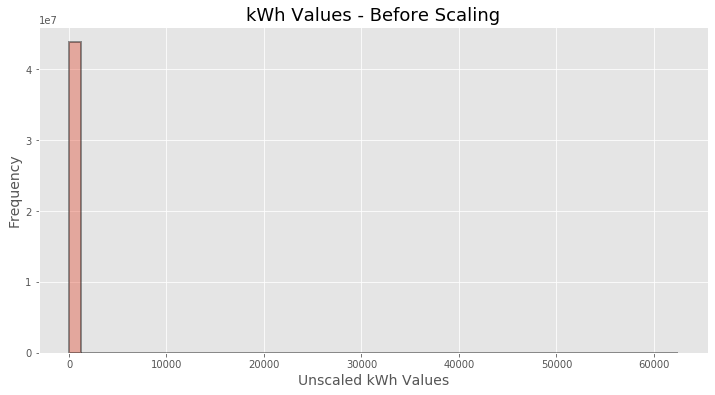

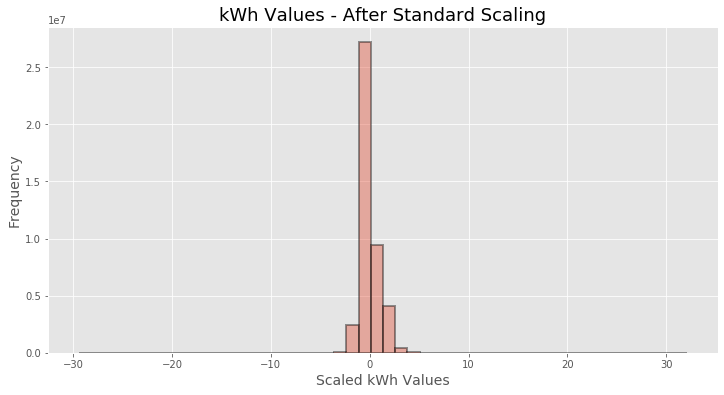

In [17]:
X_scaled_std = scale_features(X=kWhs, plot_distributions=True)

# Train-Test Split

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled_std, 
                                                    labels, 
                                                    stratify=labels, 
                                                    shuffle=True, 
                                                    test_size=0.2, 
                                                    random_state=0)

# Wide CNN - Zheng's Model

In [0]:
# Insantiate a Model
model = Sequential()

## Adding Layers

Zheng's wide model has a single layer which takes a 1034-dimensional input. 

**Number of Neurons**: The paper is unclear about the optimal number of neurons. In the description, it states that V.C.1) (Parameter Study, Effect of Alpha), it states the optimal number of neurons is 50. However, the graphs of the parameter study presented in figure 6(a)-(b) show that highest AUC is obtained when number of neurons is closer to 90.

**Activation Function**: `ReLu`, as defined in paper. 

**No regularizaton** specified. 

### `Wide` Input Layer

In [0]:
model.add(Dense(units=90, 
                activation='relu', 
                input_shape=(1034,)))

### `Sigmoid` Layer

In [0]:
model.add(Dense(units=1, activation='sigmoid'))

## Compiling Model

In [0]:
model.compile(optimizer='sgd',
              loss='binary_crossentropy', 
              metrics=[AUC()])

## Model Summary

In [42]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 90)                93150     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 91        
Total params: 93,241
Trainable params: 93,241
Non-trainable params: 0
_________________________________________________________________


## Training Model

In [43]:
wide_history = model.fit(X_train, y_train,
                         validation_split=0.2, 
                         epochs=20, 
                         verbose=1)

Train on 27117 samples, validate on 6780 samples
Epoch 1/20
27117/27117 [==============================] - 6s 215us/sample - loss: 0.3255 - auc_2: 0.5578 - val_loss: 0.3087 - val_auc_2: 0.6124
Epoch 2/20
27117/27117 [==============================] - 3s 129us/sample - loss: 0.2881 - auc_2: 0.6538 - val_loss: 0.2936 - val_auc_2: 0.6504
Epoch 3/20
27117/27117 [==============================] - 3s 129us/sample - loss: 0.2735 - auc_2: 0.6977 - val_loss: 0.2905 - val_auc_2: 0.6595
Epoch 4/20
27117/27117 [==============================] - 3s 125us/sample - loss: 0.2617 - auc_2: 0.7314 - val_loss: 0.2916 - val_auc_2: 0.6520
Epoch 5/20
27117/27117 [==============================] - 4s 131us/sample - loss: 0.2528 - auc_2: 0.7574 - val_loss: 0.2889 - val_auc_2: 0.6823
Epoch 6/20
27117/27117 [==============================] - 3s 128us/sample - loss: 0.2445 - auc_2: 0.7803 - val_loss: 0.2753 - val_auc_2: 0.7126
Epoch 7/20
27117/27117 [==============================] - 3s 125us/sample - loss: 0.235

## Model History

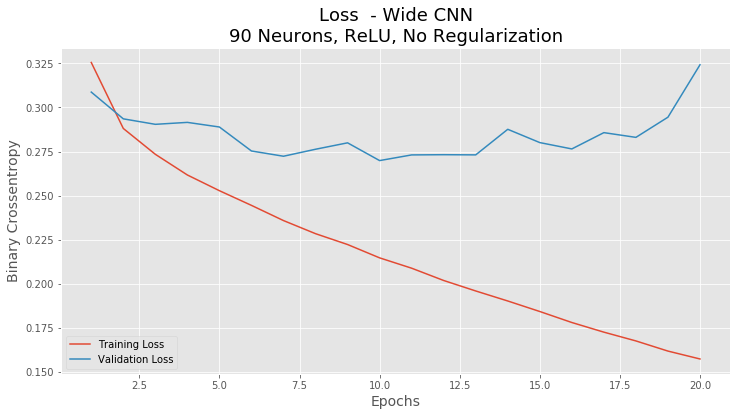

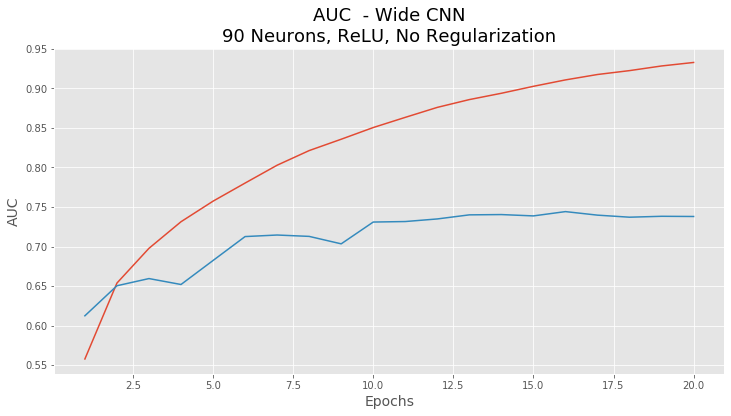

In [84]:
plot_history(history=wide_history, 
             model_name='Wide CNN\n90 Neurons, ReLU, No Regularization', 
             loss_name='Binary Crossentropy')

## Evaluation Results

**I HAVE EVALUATED THIS MODEL ON A SUBSET OF THE TRAINING DATA**.

I expect there will be a lot of hyperparameter tuning on this model going forward, so it does not make sense to evaluate it on the test data. 

Instead, I am going to extract 20% of randomly selected samples from the training set and evaluate the results on it. 

In [0]:
_, X_val, _, y_val = train_test_split(X_train, y_train,   # Splitting training data
                                      stratify=y_train,
                                      random_state=42,    # Different from previous split
                                      shuffle=True, 
                                      test_size=0.2)

CLASSIFICATION REPORT
                  precision    recall  f1-score   support

Regular Consumer       0.96      0.96      0.96      6202
           Thief       0.56      0.60      0.58       578

        accuracy                           0.93      6780
       macro avg       0.76      0.78      0.77      6780
    weighted avg       0.93      0.93      0.93      6780



CONFUSION MATRIX


ROC CURVE


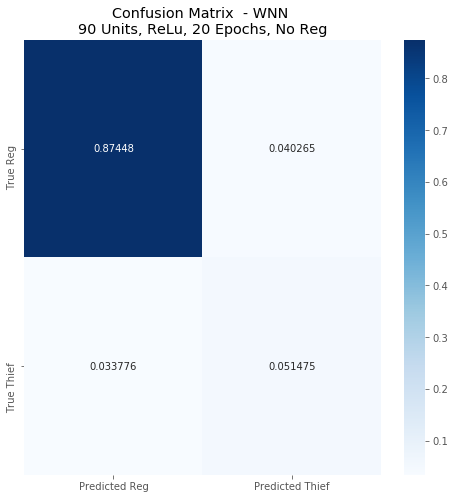

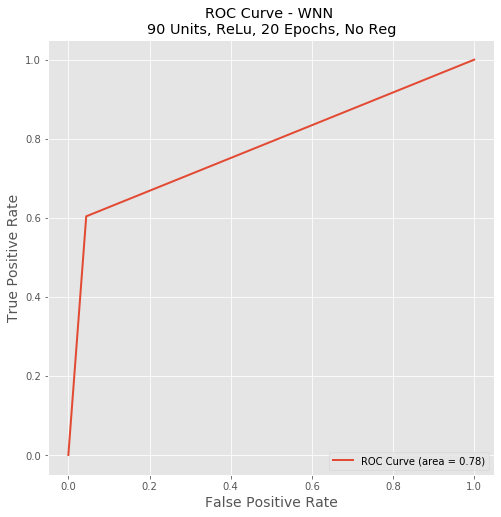

In [151]:
get_classification_result(model=model, X_test=X_val, y_true=y_val,
                          model_name='WNN \n90 Units, ReLu, 20 Epochs, No Reg')